# improve model via hypertuning of parameters

In [7]:
# setup
import sys
import os
sys.path.append(os.path.abspath('../src'))

import pandas as pd
import numpy as np
import pickle

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from scipy.stats import uniform, randint
from sklearn.metrics import classification_report

from model_helpers import preprocess_data, validate_data, evaluate_model, log_transform, plot_xgb_feature_importance
from setup_model_eval_log import log_model_evaluation

data_location = '../data/raw/psp_raw_data.xlsx'

## using GridSearch
- used 4374 
- commented out so it doesn't run

In [ ]:
'''
# Load and preprocess data
df = pd.read_excel(data_location, index_col=0)
df = preprocess_data(df)
print(validate_data(df))

# Feature lists
categorical_features = ['country', 'card', 'psp']
binary_features = ['3d_secured']  # already in correct format 1/0
numerical_features = ['amount']

# Define features and target
X = df.drop(columns=['success'])
y = df['success']

# Define preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('log_and_scale', Pipeline([
            ('log', FunctionTransformer(log_transform, validate=True)),
            ('scaler', StandardScaler())
        ]), numerical_features),
        ('cat', OneHotEncoder(drop=None), categorical_features),  # Don't drop for interpretability
        ('binary', 'passthrough', binary_features)
    ]
)

# Base classifier
classifier = XGBClassifier(random_state=42)

# Model pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', classifier)
])

# Train-test split, 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the positive class weight
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

# Define the hyperparameter grid 
param_grid = {
    'classifier__scale_pos_weight': [scale_pos_weight, 1],
    'classifier__subsample': [0.7, 0.8, 0.9],
    'classifier__colsample_bytree': [0.7, 0.8, 0.9],
    'classifier__max_depth': [5, 6, 7],
    'classifier__min_child_weight': [1, 2, 3],
    'classifier__learning_rate': [0.01, 0.05, 0.1],
    'classifier__n_estimators': [100, 200, 500]
}

# Set up GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=3, n_jobs=-1, scoring='f1', verbose=1)

# Fit GridSearchCV to the training data
grid_search.fit(X_train, y_train)

# Print best parameters and best score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best F1-score: {grid_search.best_score_}")

# Evaluate the model on the test data using your custom evaluation method
best_pipeline = grid_search.best_estimator_
evaluate_model(best_pipeline, X_test, y_test)
'''

Validation complete and successful.
None
Fitting 3 folds for each of 1458 candidates, totalling 4374 fits


## using Hybrid approach 
- randomsearch - 150 fits
- gridsearch - 486 fits
- total of 636 fits -- way less computational time, very similar result

Validation complete and successful.
None
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best parameters from Random Search: {'classifier__colsample_bytree': 0.724478254120072, 'classifier__learning_rate': 0.010518486277398677, 'classifier__max_depth': 8, 'classifier__min_child_weight': 1, 'classifier__n_estimators': 119, 'classifier__scale_pos_weight': 3.8541165142031777, 'classifier__subsample': 0.7212822750999782}
Best F1-score from Random Search: 0.39490873490637357
Fitting 3 folds for each of 162 candidates, totalling 486 fits
Best parameters from Grid Search: {'classifier__colsample_bytree': 0.724478254120072, 'classifier__learning_rate': 0.005259243138699339, 'classifier__max_depth': 7, 'classifier__min_child_weight': 2, 'classifier__n_estimators': 119, 'classifier__scale_pos_weight': 3.8541165142031777, 'classifier__subsample': 0.7212822750999782}
Best F1-score from Grid Search: 0.3992754818063824


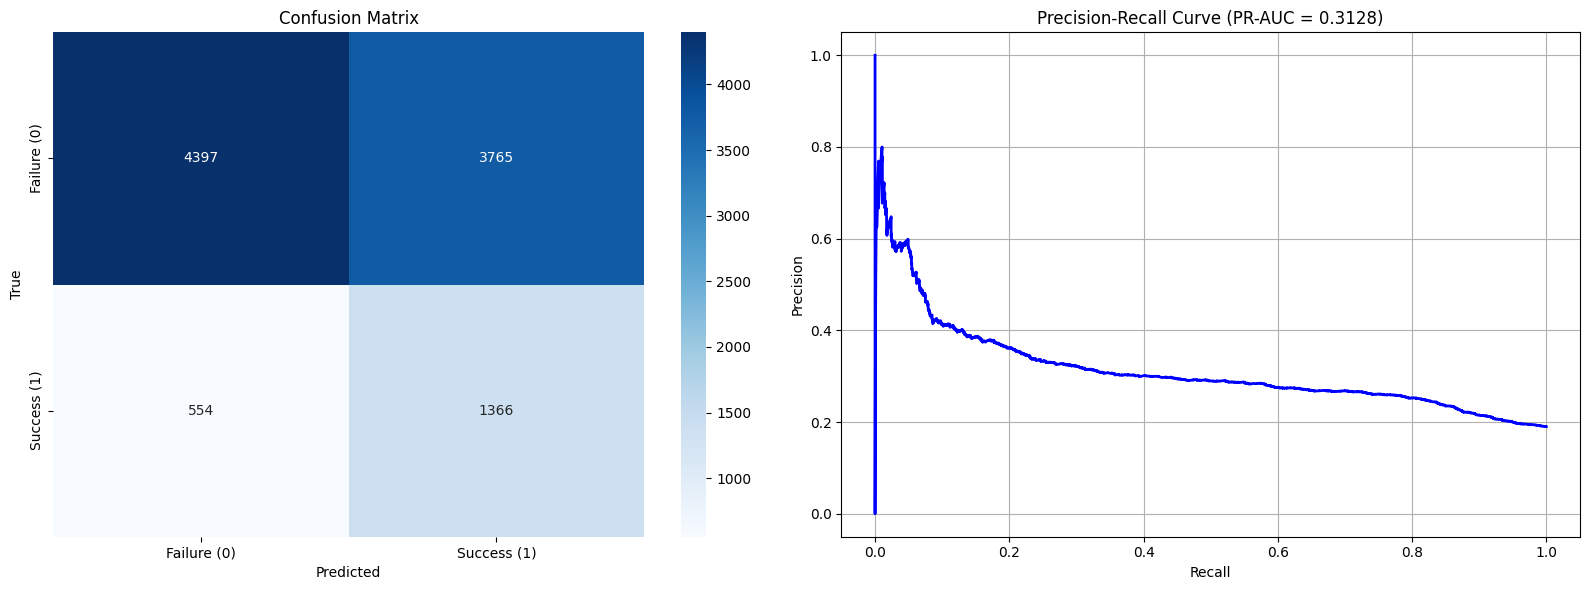


Classification Report:


,precision,recall,f1-score,support
Failure (0),0.888103,0.538716,0.670632,8162.000000
Success (1),0.266225,0.711458,0.387463,1920.000000
accuracy,0.571613,0.571613,0.571613,0.571613
macro avg,0.577164,0.625087,0.529047,10082.000000
weighted avg,0.769674,0.571613,0.616706,10082.000000


Best F1-Score: 0.3893 at Threshold: 0.4979
Total Model F1-Score: 0.3875
Total Model Precision: 0.2662


In [8]:
# Load and preprocess data
df = pd.read_excel(data_location, index_col=0)
df = preprocess_data(df)
print(validate_data(df))

# Feature lists
categorical_features = ['country', 'card', 'psp']
binary_features = ['3d_secured']  # already in correct format 1/0
numerical_features = ['amount']

# Define features and target
X = df.drop(columns=['success'])
y = df['success']

# Define preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('log_and_scale', Pipeline([
            ('log', FunctionTransformer(log_transform, validate=True)),
            ('scaler', StandardScaler())
        ]), numerical_features),
        ('cat', OneHotEncoder(drop=None), categorical_features),  # Don't drop for interpretability
        ('binary', 'passthrough', binary_features)
    ]
)

# Base classifier
classifier = XGBClassifier(random_state=42)

# Model pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', classifier)
])

# Train-test split, 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the positive class weight for imbalanced dataset
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

# Define the hyperparameter grid for RandomizedSearchCV
param_dist = {
    'classifier__scale_pos_weight': [scale_pos_weight, 1],
    'classifier__subsample': uniform(0.7, 0.3),
    'classifier__colsample_bytree': uniform(0.7, 0.3),
    'classifier__max_depth': randint(5, 10),
    'classifier__min_child_weight': randint(1, 4),
    'classifier__learning_rate': uniform(0.01, 0.1),
    'classifier__n_estimators': randint(100, 1000)
}

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(pipeline, param_distributions=param_dist, n_iter=50, cv=3, n_jobs=-1, scoring='f1', verbose=1, random_state=42)

# Fit RandomizedSearchCV to the training data
random_search.fit(X_train, y_train)

# Print best parameters and best score from random search
print(f"Best parameters from Random Search: {random_search.best_params_}")
print(f"Best F1-score from Random Search: {random_search.best_score_}")

# Narrow down with GridSearchCV using the best parameters from RandomizedSearchCV
param_grid = {
    'classifier__scale_pos_weight': [random_search.best_params_['classifier__scale_pos_weight'], 1],
    'classifier__subsample': [random_search.best_params_['classifier__subsample']],
    'classifier__colsample_bytree': [random_search.best_params_['classifier__colsample_bytree']],
    'classifier__max_depth': [random_search.best_params_['classifier__max_depth'] - 1, random_search.best_params_['classifier__max_depth'], random_search.best_params_['classifier__max_depth'] + 1],
    'classifier__min_child_weight': [random_search.best_params_['classifier__min_child_weight'] - 1, random_search.best_params_['classifier__min_child_weight'], random_search.best_params_['classifier__min_child_weight'] + 1],
    'classifier__learning_rate': [random_search.best_params_['classifier__learning_rate'] * 0.5, random_search.best_params_['classifier__learning_rate'], random_search.best_params_['classifier__learning_rate'] * 1.5],
    'classifier__n_estimators': [random_search.best_params_['classifier__n_estimators'] - 50, random_search.best_params_['classifier__n_estimators'], random_search.best_params_['classifier__n_estimators'] + 50]
}

# Set up GridSearchCV for fine-tuning
grid_search = GridSearchCV(pipeline, param_grid, cv=3, n_jobs=-1, scoring='f1', verbose=1)

# Fit GridSearchCV to the training data
grid_search.fit(X_train, y_train)

# Print best parameters and best score from GridSearchCV
print(f"Best parameters from Grid Search: {grid_search.best_params_}")
print(f"Best F1-score from Grid Search: {grid_search.best_score_}")

# Evaluate the model
pipeline = grid_search.best_estimator_
evaluate_model(pipeline, X_test, y_test)

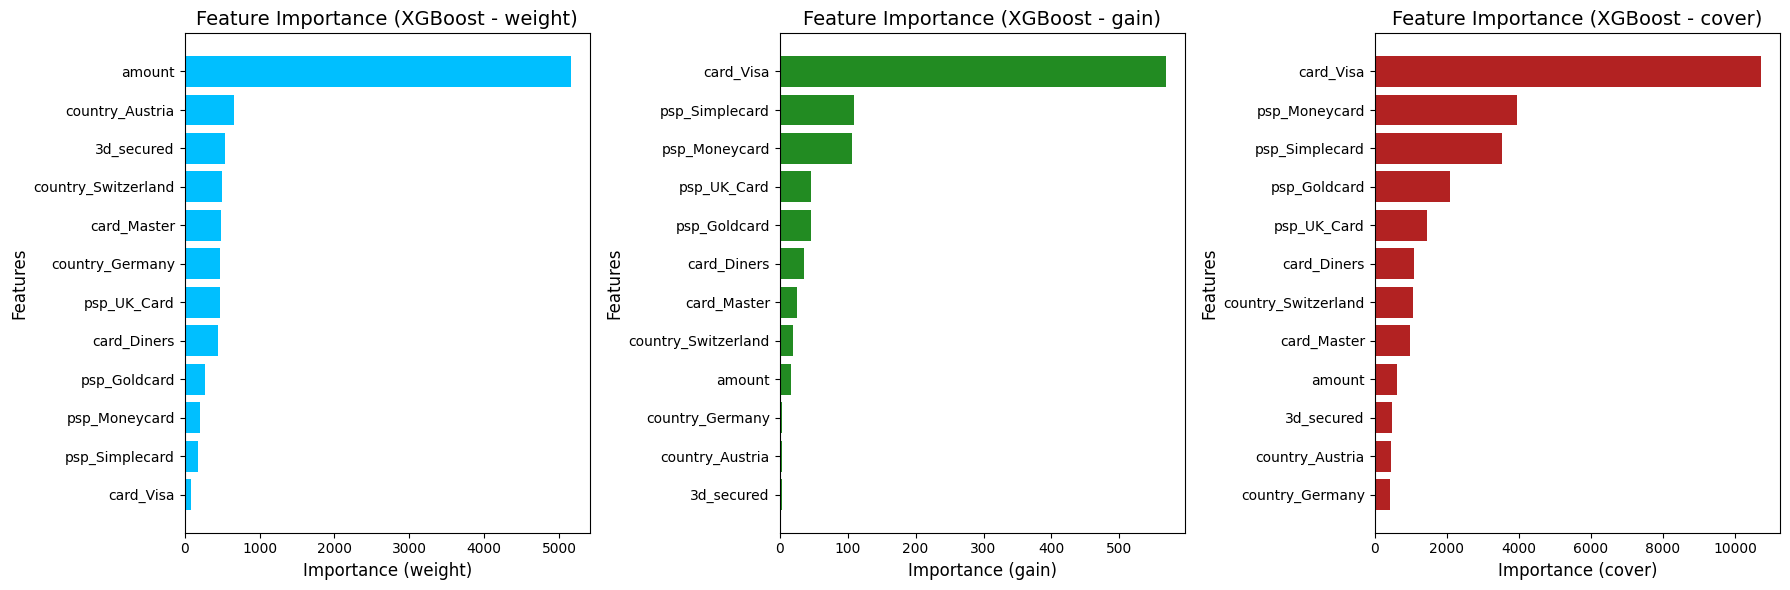

Feature Importance (Weight): {'amount': 5155.0, 'country_Austria': 655.0, '3d_secured': 545.0, 'country_Switzerland': 501.0, 'card_Master': 489.0, 'country_Germany': 471.0, 'psp_UK_Card': 468.0, 'card_Diners': 450.0, 'psp_Goldcard': 274.0, 'psp_Moneycard': 208.0, 'psp_Simplecard': 175.0, 'card_Visa': 80.0}
Feature Importance (Gain): {'card_Visa': 568.0570678710938, 'psp_Simplecard': 109.65699005126953, 'psp_Moneycard': 105.84036254882812, 'psp_UK_Card': 45.91420364379883, 'psp_Goldcard': 45.50312042236328, 'card_Diners': 35.318206787109375, 'card_Master': 26.12652015686035, 'country_Switzerland': 19.03081703186035, 'amount': 16.36185073852539, 'country_Germany': 3.703888416290283, 'country_Austria': 3.5335142612457275, '3d_secured': 3.2453486919403076}
Feature Importance (Cover): {'card_Visa': 10708.248046875, 'psp_Moneycard': 3955.36279296875, 'psp_Simplecard': 3519.955322265625, 'psp_Goldcard': 2078.633544921875, 'psp_UK_Card': 1460.3739013671875, 'card_Diners': 1086.5479736328125, '

In [9]:
# plot importance scores 
importance_scores = plot_xgb_feature_importance(pipeline, numerical_features, binary_features, categorical_features)

print("Feature Importance (Weight):", importance_scores['weight'])
print("Feature Importance (Gain):", importance_scores['gain'])
print("Feature Importance (Cover):", importance_scores['cover'])

### Feature Importance Analysis

1. **Amount**:
   - **Weight**: Very high (5155), indicating it plays a significant role in splitting decisions.
   - **Gain**: Moderate (16.36), indicating a lower contribution to model improvement compared to categorical features.
   - **Cover**: Lower (623.75), suggesting less frequent use in tree splits compared to categorical features.

2. **Categorical Features** (e.g., `country_*`, `card_*`, `psp_*`):
   - **Weight**: Lower than `amount`, but still relevant (e.g., `country_Austria` with 655, `psp_UK_Card` with 468).
   - **Gain**: High for `card_Visa` (568.05), `psp_Simplecard` (109.66), and others, reflecting their importance in improving the model.
   - **Cover**: Significant for features like `card_Visa` (10708.25) and `psp_Moneycard` (3955.36), indicating their frequent use in tree splits.

### Key Insights
- **`amount`** dominates in **Weight** due to its unencoded nature.
- Categorical features, once encoded, have **higher Gain** and **Cover**, making them crucial for model performance despite lower Weight.


### Evaluate overall model performance in terms of over/underfitting

In [10]:
# Evaluate on training data
y_train_pred = pipeline.predict(X_train)  # Using best pipeline from random search
train_report = classification_report(y_train, y_train_pred)

# Evaluate on test data
y_test_pred = pipeline.predict(X_test)  # Using best pipeline from random search
test_report = classification_report(y_test, y_test_pred)

# Print both classification reports
print("Train Classification Report:")
print(train_report)
print("\nTest Classification Report:")
print(test_report)

Train Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.54      0.67     32020
           1       0.29      0.72      0.41      8308

    accuracy                           0.58     40328
   macro avg       0.59      0.63      0.54     40328
weighted avg       0.76      0.58      0.62     40328


Test Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.54      0.67      8162
           1       0.27      0.71      0.39      1920

    accuracy                           0.57     10082
   macro avg       0.58      0.63      0.53     10082
weighted avg       0.77      0.57      0.62     10082



## Cross-Validation to check for overfiitting

In [11]:

# Define the number of folds (e.g., 5-fold cross-validation)
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Perform cross-validation with F1 score (as we are dealing with imbalanced classes)
cv_scores = cross_val_score(pipeline, X, y, cv=cv, scoring='f1', n_jobs=-1)

# Print cross-validation results
print(f"Cross-Validation F1 Scores: {cv_scores}")
print(f"Mean F1 Score: {np.mean(cv_scores):.4f}")
print(f"Standard Deviation of F1 Scores: {np.std(cv_scores):.4f}")


Cross-Validation F1 Scores: [0.38309193 0.40204327 0.39976959 0.39213384 0.40126838 0.38637734
 0.38941616 0.3989547  0.39369159 0.39123912]
Mean F1 Score: 0.3938
Standard Deviation of F1 Scores: 0.0062


### Conclusion

- **Cross-Validation F1 Score**: The mean F1 score across the 10-fold cross-validation is 0.3938, reflecting the model's ability to balance precision and recall despite the class imbalance.

- **Model Stability**: With a low standard deviation of 0.0062, the model demonstrates consistent performance across different subsets of the data. This indicates that the model is not overly sensitive to the specific train-test splits and can generalize reasonably well.

- **Overfitting**: The relatively stable F1 scores across the folds suggest that the model is not overfitting. The consistency in performance indicates the model is generalizing effectively to unseen data.

In conclusion, the model exhibits a good balance between precision and recall, with stable performance across multiple folds, suggesting a robust model that is not overfitting.


### Model Analysis

#### Cross-Validation Results:
- **Mean F1 Score**: 0.3939
- **Standard Deviation of F1 Scores**: 0.0030

#### Inferences:
1. **Low F1 Score**: 
   - The model is struggling to balance precision and recall for the positive class (label `1`).
   - The **recall** for the minority class (class `1`) may be high, but **precision** is likely low, leading to a low F1 score.
   - This indicates that the model is classifying some positives incorrectly (false positives).

2. **Consistency**: 
   - The low **standard deviation** suggests that the model’s performance is stable across different data subsets (folds in cross-validation).
   - While the model’s performance is consistent, it isn’t performing well on this dataset.

####  Conclusion: 
- Model is not overfit, but struggles to learn meaningful patterns. 
- Regularization is not neccessary. 



## save model and log performance

In [12]:
model_name = "xgboost_hypertuned_model"
# Save Model and Log 
log_model_evaluation(
    model=pipeline,
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    model_name=model_name,
    notes="Hyperparameters tuned for imbalance."
)

# pickle model 
with open('../models/xgboost_hypertuned_model.pkl', 'wb') as model_file:
    pickle.dump(pipeline, model_file)

../models/evaluation/model_evaluation_log.csv already exists. New entries will be appended.
